# About this notebook
This notebook combines the outputs from MetaCycle (circadian genes), and the 2kb sequences upstream from their promoter region across seven genotypes.

# Libraries

In [ ]:
import pandas as pd
import glob

# Combine gff3 with promoter sequence

In [ ]:
%%time

# List gff3 and bed files
gff3_files = glob.glob('../output/GFF3_gene_only//*.gff3', recursive=False)
bed_files = glob.glob('../output/Regions/*.2kb.promoters.bed', recursive=False)

# CReate empty dataframe
All_regions = pd.DataFrame()
# List the seven genotypes
genotypes = ['L58','R500','WO_83','PCGlu','VT123','A03','O_302V']

for g in genotypes:
    
    # Current genotype (cg)
    cg = g
    
    # Match genotype with gff3 file
    gff3_genes = next(x for x in gff3_files if cg in x)
    df_gff3 = pd.read_csv(gff3_genes, sep="\t", header=None, comment="#") # read
    # Define colnames
    gff3_names = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    df_gff3.columns = gff3_names
    # Get gene name
    df_gff3['gene'] = df_gff3['attributes'].apply(lambda x: x.split('Name=')[1])

    # Match genotype with bed file 
    region_genes = next(x for x in bed_files if cg in x)
    df_region = pd.read_csv(region_genes, sep="\t", header=None, comment="#") # read
    region_names = ["attributes", "region2kb"] # colnames
    df_region.columns = region_names
    # Get position
    df_region['position'] = df_region['attributes'].apply(lambda x: x.split('::')[1])
    # Get gene name
    df_region['gene'] = df_region['attributes'].apply(lambda x: x.split('::')[0])
    df_region['gene'] = df_region['gene'].apply(lambda x: x.split('Name=')[1])
    df_region = df_region.drop('attributes', axis=1) # remove unnecessary column

    # Merge gff3 with bed file
    merged_df = pd.merge(df_gff3, df_region, on='gene')
    
    # Append to df
    All_regions = pd.concat([All_regions,merged_df])
    

# Circadian Genes

In [ ]:
%%time
# Read output form MetaCycle
CircadianGenes = '../output/MetaCycle/CircadianGenes.csv'
CircadianGenes = pd.read_csv(CircadianGenes)
# Get gene name to match with promoter
CircadianGenes = CircadianGenes.rename(columns={'NewCycID': 'gene'})
# Merge files
CircRegions_2kb = pd.merge(CircadianGenes,All_regions, on='gene')
# Write as csv (probably not the ideal format)
CircRegions_2kb.to_csv('../output/CircadianRegions_2kb.csv')

# Machine learning

**Libraries and settings**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import time
import pytz
from datetime import datetime

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.dpi']= 100
plt.rcParams["axes.grid"] = False
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

/Users/joanbarreto/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read the regions
CircadianRegions = '../output/CircadianRegions_2kb.csv'
CircadianRegions = pd.read_csv(CircadianRegions)

# Sample (for testing)
CircadianRegions = CircadianRegions.sample(frac=0.5, replace=False, random_state=1)


data_df = CircadianRegions[['gene','JTK_adjphase','region2kb']] # keep relevant cols
data_df = data_df.sort_values('gene')

In [3]:
%%time
# ~5 sec on Joan's Mac

# Use an 8bp window and 3bp overlap
window_size = 8
overlap = 3
non_overlap = window_size-overlap
regions = data_df['region2kb'] 
# Slide window and get features
Features = regions.apply(lambda x: [x[i:i+window_size] for i in range(0, len(x)-7, non_overlap)])
Features.name = "features" # Rename
# Get unique features
unique_features = [item for sublist in Features for item in sublist]
unique_features = set(unique_features)

# CReate features df 
features_df = pd.concat([data_df['gene'], Features], axis=1)

CPU times: user 2.28 s, sys: 166 ms, total: 2.45 s
Wall time: 2.44 s


In [4]:
%%time
# ~38.5 sec on Joan's Mac

# Set MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the binarizer to the "features" column and transform it
one_hot = mlb.fit_transform(features_df["features"])

# Create a new df with the one-hot encoding and the gene column
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df["gene"] = features_df["gene"].values

# Bring "gene" col to front
one_hot_df = one_hot_df[["gene"] + list(mlb.classes_)]
one_hot_df = one_hot_df.set_index('gene') # Set gene as index
feature_names = np.array(one_hot_df.columns) # get feature names

CPU times: user 24.6 s, sys: 17.4 s, total: 42 s
Wall time: 51.3 s


In [ ]:
# Copy data
df = one_hot_df
# Remove features containin "N" (only 6)
df = df.loc[:, ~df.columns.str.contains('N')]


Here are two ideas:

(1) density-based filtering:
I’d suggest doing an initial filtering on your 66k features that is based on the feature sparsity. I would plot the distribution of feature density for all 66k and cut anything in bottom ~25% in terms of density (number of 1s across samples) and maybe those in the top ~25% in terms of density. If you want to filter more, just adjust those cutoffs on the tails according to your intuition. (How dense do you think the informative features are likely to be?)

## Density-based filtering

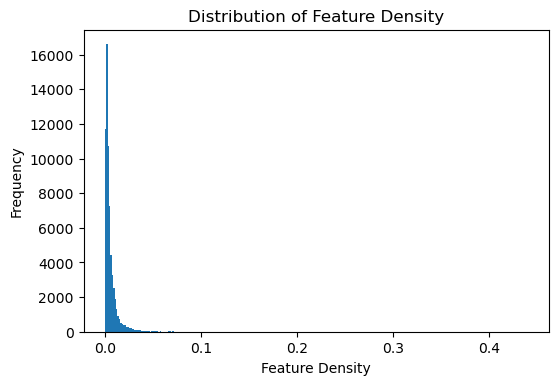

In [74]:
df = one_hot_df

# Get densities
feature_densities = df.sum() / df.shape[0]
feature_densities = feature_densities.sort_values(ascending=False)

# Create a histogram of the feature density values
plt.hist(feature_densities, bins=300)
plt.xlabel("Feature Density")
plt.ylabel("Frequency")
plt.title("Distribution of Feature Density")
plt.show();

In [84]:
# Filter out bottom 25% and top 25% (or more)

# Calculate the nth percentile values
bottom_25 = np.percentile(feature_densities, 25)
top_25 = np.percentile(feature_densities, 75)

filtered_series = feature_densities[
    (feature_densities > bottom_25) & (feature_densities < top_25)]

filtered_features = filtered_series.index.to_list()
filtered_features = df[filtered_features]



After filtering by density, I’d apply something like this

(2) redundancy-based filtering:

Sort the features in some reasonable way (eg highest to lowest density)
Perform this iteration:

Select the top remaining feature.

Compare to each of the already selected features in terms of cosine similarity

If the highest cos similarity is lower than X, accept that feature. If not, reject it


Note that I would not use the class labels for that feature selection— that will just complicate your pipeline at this point as you’ll need to avoid training/test set leaks.

With the combination of those two filters, I would target ~5-10k features total.

It would also be fine to just run PCA on those features— PCA is used a lot on genotype data, which is similarly qualitative (non-continuous) to your features. But getting PCA to run in 66k features won’t be easy either— it’s probably easiest to use the simpler approaches above.

In [ ]:
%%time

# Copy df
df = filtered_features.iloc[:,:1000]

# Initialize a list to store the selected feature indices
selected_features = [df.columns[0]]

# Loop until all features have been selected or rejected
while len(selected_features) < df.shape[1]:

    # Get last selected feature (Feature_X)
    Feature_X = df[selected_features[-1]].astype(bool).to_numpy().reshape(1, -1) #bool
    Feature_X = Feature_X.astype(int) # Needs to be a binary array
    
    # Select the top remaining feature that hasn't been selected yet (Feature_Y)
    remaining_features = df.drop(selected_features, axis=1, errors='ignore')
    top_remaining = filtered_series[remaining_features.columns].idxmax()
    Feature_Y = df[top_remaining].astype(bool).to_numpy().reshape(1, -1)
    Feature_Y = Feature_Y.astype(int)
    # Compute cosine similarity
    cos_similarity = cosine_similarity(Feature_X, Feature_Y)
    cos_similarity = cos_similarity[0][0]
    
    # Accept feature is absolute value is greater than 75%
    if abs(cos_similarity) > 0.75:
        selected_features.append(top_remaining)
    # Drop next top col
    df = df.drop(top_remaining, axis=1)
    
# Filtered dataset
filtered_df = one_hot_df.loc[:, selected_features]



In [109]:
%%time

df = filtered_features

# standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(df)

# perform PCA with n components
n_comp = 30
pc_names = ['PC{:02d}'.format(i) for i in range(1, n_comp+1)]

pca = PCA(n_components=n_comp)
pca.fit(X_std)

# transform the data to the new PCA space
X_pca = pca.transform(X_std)

# create a new dataframe with the PCA components
df_pca = pd.DataFrame(X_pca, columns=pc_names)

# add the original feature names as column names
df_pca.columns = pc_names
df_pca.index = df.index

CPU times: user 3min 6s, sys: 4min 4s, total: 7min 10s
Wall time: 2min 37s


In [110]:
%%time

# get the loadings of each feature on each principal component
loadings = pca.components_

# convert the loadings to a pandas dataframe
df_loadings = pd.DataFrame(loadings.T, columns=pc_names, index=df.columns)

# sort the rows (i.e., features) of the dataframe by their absolute loading value in descending order
df_loadings = df_loadings.apply(lambda x: x.abs().sort_values(ascending=False), axis=0)


CPU times: user 316 ms, sys: 79.9 ms, total: 396 ms
Wall time: 282 ms


In [111]:
%%time

selected_features=[]

for pc in pc_names:
    pc_column = pc # current PC
    pc_sorted = df_loadings[pc_column].sort_values(ascending=False) # sort loadings
    half_features = int(0.10 * len(pc_sorted.index)) # Select 10% of the features
    features_PC = list(pc_sorted[:half_features].index)
    selected_features.extend(features_PC)
    # len(selected_features)

CPU times: user 133 ms, sys: 12.3 ms, total: 145 ms
Wall time: 144 ms


In [ ]:
unique_features = np.unique(selected_features)
n_unique_features = len(unique_features) # get number of features
# Filtered dataset
filtered_df = one_hot_df.loc[:, unique_features]
# Export
filename = '../output/FilteredFeatures_PCA_n' + str(n_unique_features) + '.csv'
filtered_df.to_csv(filename)

In [115]:
# print the explained variance ratios for each principal component
print(pca.explained_variance_ratio_)

[0.00049326 0.00031647 0.00026379 0.00025696 0.00025569 0.00024089
 0.00022411 0.00022174 0.00021981 0.0002093  0.0002042  0.00020262
 0.0001986  0.00019396 0.00019273 0.0001919  0.0001876  0.00018627
 0.00018476 0.00018252 0.00018065 0.00017991 0.00017697 0.00017602
 0.00017421 0.00017153 0.00017007 0.00016952 0.00016935 0.00016844]


In [116]:
# Filtered dataset
filtered_df = one_hot_df.loc[:, unique_features]


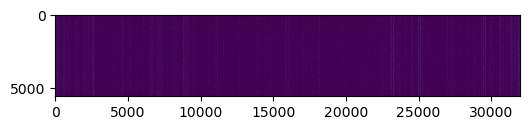

In [483]:
df_img = np.array(filtered_df)
plt.imshow(df_img)

In [458]:
max(filtered_df)

'TTTGGGGC'

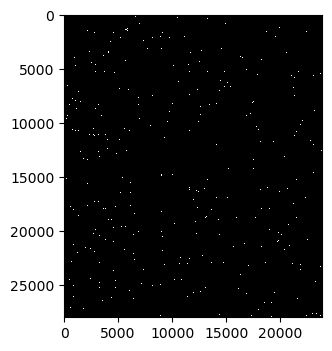

In [117]:
# plt.imshow(filtered_df, cmap='gray', interpolation='nearest')
# plt.imshow(filtered_features, cmap='gray', interpolation='nearest')
plt.imshow(filtered_df, cmap='gray', interpolation='nearest')


In [ ]:
%%time

# Data for models
X_features = one_hot_df
Y_target = data_df["JTK_adjphase"]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=5461)

In [ ]:
model_name = 'LR'

# Create an instance of the model
model = LinearRegression()

# Train the algorithm on the training set
model.fit(X_train, y_train)

# Use the trained algorithm to predict the target variable of the test set
y_pred = model.predict(X_test)

# Evaluate the performance using Pearson and mean squared error
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
performance_df = pd.DataFrame({'Model':model_name,'PCC':PCC,'MSE':mse},index=[0])

# Get coefficients (importance)
coefficients = lr.coef_
# Create feature importance df for model
colname =  model_name + '_Importance'
FI_df = pd.DataFrame({'Feature': feature_names, colname: coefficients})
FI_df = FI_df.sort_values(by=[colname], ascending=False)


In [ ]:
Models_List = [LinearRegression(), 
               SVR(kernel='rbf', C=1000, gamma=0.1)]
# Models_List[0]

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1000, gamma=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
performance_df = pd.DataFrame({'Model':model_name,'PCC':PCC,'MSE':mse,'ExecTime':execution_time},index=[0])

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')

Models = {'rfr':rfr,'svr':svr,'gbr':gbr,'knn':knn}

next(iter(Models)) # outputs 'foo'


In [ ]:
# One hot encoding -----------

# Create features df
features_df = pd.concat([data_df['gene'], Features], axis=1)
# Set and fit MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(features_df["features"]) # fit
# Create a new df with the one-hot encoding and the gene column
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df["gene"] = features_df["gene"].values
one_hot_df = one_hot_df[["gene"] + list(mlb.classes_)] # "gene" col to front
one_hot_df = one_hot_df.set_index('gene') # Set gene as index
feature_names = np.array(one_hot_df.columns) # get feature names



# Split data for training -----------

# Data for models
X_features = one_hot_df
Y_target = data_df["JTK_adjphase"]
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=5461)

In [ ]:
# Select and train models -----------

# Create empty dfs to output
ModelsPerformance = pd.DataFrame()
FeatureImportance = pd.DataFrame()

# Create models
knn = KNeighborsRegressor(n_neighbors=5)
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
# Store them in dictionary
Models = {'rfr':rfr,
          'svr':svr,
          'gbr':gbr,
          'knn':knn}

# Select model
model_name = next(iter(Models)) # Name
model = next(iter(Models.values())) # Model

# Train the algorithm on the training set
start_time = time.time() # ***** Start timer *****
model.fit(X_train, y_train)

# Use the trained algorithm to predict the target variable of the test set
y_pred = model.predict(X_test)

# Feature importance
if model_name == 'rfr' | model_name == 'gbr':
    feature_importance = model.feature_importances_
    # Create feature importance df for model
    colname =  model_name + '_Importance'
    FI_df = pd.DataFrame({'Feature': feature_names, colname: coefficients})
    FI_df = FI_df.sort_values(by=[colname], ascending=False)
    # Append to greater df
    FeatureImportance = pd.concat([FeatureImportance,FI_df], axis=0) 


end_time = time.time() # ***** End timer *****
# Time to run
execution_time = round(end_time - start_time, 4)
print('Finished model ',model_name)

                  
# Performance -----------
                  
# Get performance metrics into a df
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
performance_df = pd.DataFrame({'Model':model_name,
                               'PCC':PCC,
                               'MSE':mse,
                               'ExecTime':execution_time},index=[0])
# Append to performance df
ModelsPerformance = pd.concat([ModelsPerformance,performance_df], axis=0)


In [1]:
import datetime
import pytz

# Set the timezone (tz) to Central Daylight Time
tz = pytz.timezone('US/Central')
# Get the current time 
now = datetime.datetime.now(tz).strftime('%Y%m%d_%H%M')
now
# # Format the datetime string
# date_str = now.strftime('%Y%m%d_%H%M')

# # Print the formatted string
# print(date_str)

'20230429_1837'

## Neural Network 

In [ ]:
%%time

nn_model = MLPRegressor(hidden_layer_sizes=(100, 100))
nn_model.fit(X_train, y_train)

# Use the trained algorithm to predict the target variable of the test set
y_pred = nn_model.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
print("Mean squared error: ", mse)
print("\nPCC: ", PCC)

## Decision Tree Regressor

In [ ]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Use the trained algorithm to predict the target variable of the test set
y_pred = dt_model.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
print("Mean squared error: ", mse)
print("\nPCC: ", PCC)

## Random Forest

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Use the trained algorithm to predict the target variable of the test set
y_pred = rf_model.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
print("Mean squared error: ", mse)
print("\nPCC: ", PCC)

## Support Vector Regression (SVR) 

In [ ]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
# Use the trained algorithm to predict the target variable of the test set
y_pred = svr_model.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
PCC = round(np.corrcoef(y_test, y_pred)[0,1],2)
print("Mean squared error: ", mse)
print("\nPCC: ", PCC)

In [ ]:
L = df['region2kb'].apply(lambda x: [x[i:i+window_size] for i in range(0, len(x)-7, non_overlap)])


In [ ]:
start_time = time.time() # ***** Start timer *****
end_time = time.time() # ***** End timer *****

execution_time = round(end_time - start_time, 4)
execution_time